<a href="https://www.kaggle.com/code/vedatgul/emotion-recognition-application-with-keras?scriptVersionId=157849606" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Emotion Recognition Application with Keras from Facial Images

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical  # Change here
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv("/kaggle/input/fer2013/fer2013.csv")
data.shape

(35887, 3)

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
np.unique(data["Usage"].values.ravel())

print('Number of samples in the training set: %d'%(len(data[data.Usage == "Training"])))

Number of samples in the training set: 28709


In [6]:
# We just put the training samples into the train_data variable
train_data = data [data.Usage == "Training"]

In [7]:
# Assuming you have already split the pixel values
train_pixels = train_data.pixels.str.split(" ").tolist()

# Creating DataFrame without specifying dtype
train_pixels = pd.DataFrame(train_pixels)

# Converting to numpy array
train_images = train_pixels.values

# If you need to convert to float explicitly
train_images = train_images.astype(np.float64)

print(train_images)

print(train_images.shape)


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [8]:
# Let's define a function to display the image as 48x48 pixels
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

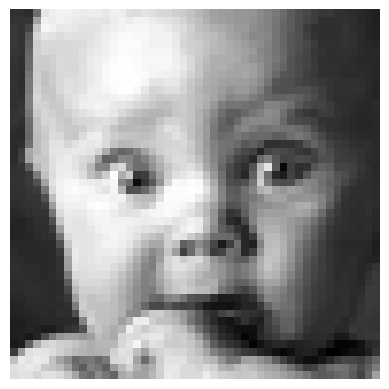

In [9]:
# An example image from the training set

show(train_images[750])

In [10]:
# Let's see how many classes are in the training set

train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Number of different facial expressions: %d'%train_labels_count)

Number of different facial expressions: 7


In [11]:
# Let's see the class of each data in the training set, that is, the size of the training process, with One Hot.

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


In [12]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)
     

(28709, 7)


# TEST DATA PREPROCESSING STEPS

In [13]:
np.unique(data["Usage"].values.ravel()) 

print('Number of samples in the test dataset: %d'%(len(data[data.Usage == "PublicTest"])))

Number of samples in the test dataset: 3589


In [14]:
test_data = data[data.Usage == "PublicTest"] 

# Assuming you have already split the pixel values
test_pixels = test_data.pixels.str.split(" ").tolist()

# Creating DataFrame without specifying dtype
test_pixels = pd.DataFrame(test_pixels)

# Converting to numpy array
test_images = test_pixels.values

# If you need to convert to float explicitly
test_images = test_images.astype(np.float64)

print(test_images.shape)

(3589, 2304)


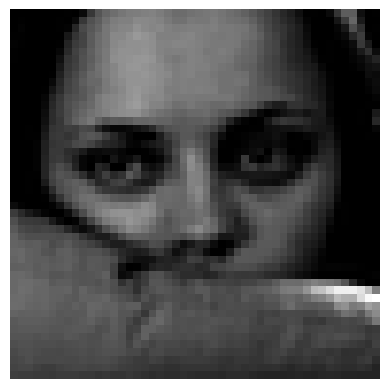

In [15]:
# An example image from the training set
show(test_images[150])

In [16]:
# Let's see the class of each data in the test set, that is, the size of the training process, with One Hot.

test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


# SAMPLE IMAGES FROM THE TEST SET

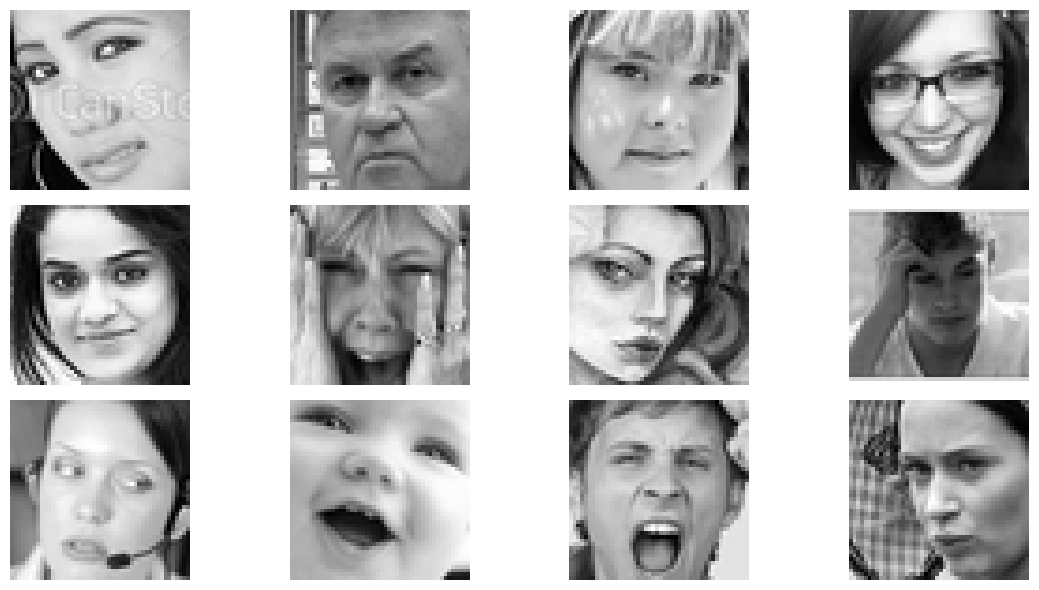

In [17]:
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

In [18]:
# DEFINING A DEEP CONVOLUTIONARY NEURAL NETWORK MODEL

model = Sequential()

#1. LAYER
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. LAYER

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #60% forgetting process (neuron deletion-dropout)

### 3. LAYER
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. LAYER
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. LAYER
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #60% forgetting process (neuron deletion-dropout)

### FULL CONNECTION LAYER
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6)) #60% forgetting process (neuron deletion-dropout)

### OUTPUT LAYER

# Classification process (there are 7 emotion classes)
model.add(Dense(7))
model.add(Activation('softmax')) 

# Determination of optimization and performance calculation metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [19]:
# Let's print the number of elements, height and width, and number of channels information of the Training and Test sets on the screen.
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [20]:
# Number of elements and emotion classes of Training and Test sets.

print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


In [21]:
# Determining the values such as epoch and batch size at which we want the training process to take place and saving the weights as an .h5 file as a result of the training.
checkpointer = ModelCheckpoint(filepath= 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 10
batchSize = 100

# Run the model

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)
                
# save model to json
model_json = model.to_json()
with open('data/face_model.json', 'w') as json_file:
  json_file.write(model_json)
     

Epoch 1/10


2024-01-05 21:42:50.439807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 1.61691, saving model to data/face_model.h5
288/288 - 14s - loss: 1.9953 - accuracy: 0.2540 - val_loss: 1.6169 - val_accuracy: 0.3717 - 14s/epoch - 47ms/step
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.61691 to 1.50371, saving model to data/face_model.h5
288/288 - 6s - loss: 1.6679 - accuracy: 0.3426 - val_loss: 1.5037 - val_accuracy: 0.4160 - 6s/epoch - 21ms/step
Epoch 3/10

Epoch 3: val_loss improved from 1.50371 to 1.46220, saving model to data/face_model.h5
288/288 - 6s - loss: 1.5582 - accuracy: 0.3944 - val_loss: 1.4622 - val_accuracy: 0.4252 - 6s/epoch - 21ms/step
Epoch 4/10

Epoch 4: val_loss improved from 1.46220 to 1.38209, saving model to data/face_model.h5
288/288 - 6s - loss: 1.4789 - accuracy: 0.4239 - val_loss: 1.3821 - val_accuracy: 0.4678 - 6s/epoch - 21ms/step
Epoch 5/10

Epoch 5: val_loss improved from 1.38209 to 1.33957, saving model to data/face_model.h5
288/288 - 6s - loss: 1.4177 - accuracy: 0.4507 - val_loss: 1.3396 - val_accuracy: 0.4804 - 6s/epoch - 21ms/step
Epoch 6/10

Epoch 6: val_loss improved from 1.33957 to 1.29797, saving model to data/face_model.h5
288/288 - 6s - loss: 1.3731 - accuracy: 0.4728 - val_loss: 1.2980 - 

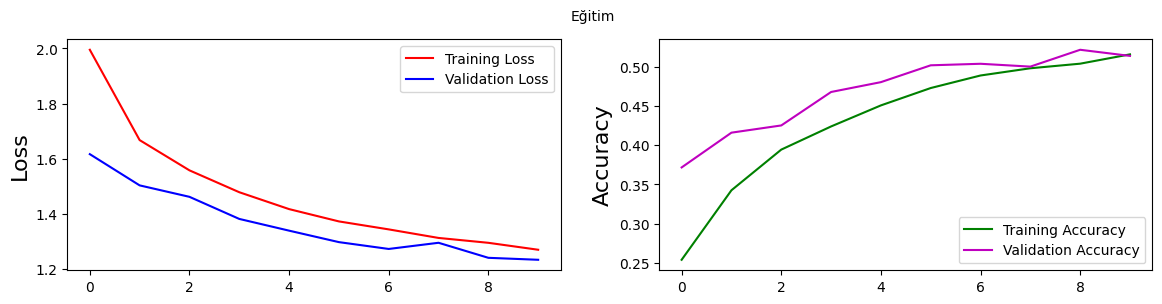

In [22]:
# Process of expressing the Training and Validation results obtained as a result of the training graphically and printing them on the screen.import numpy as np

plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [23]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [24]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [25]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("Accuracy status on Private Test:", score)

Accuracy status on Private Test: [1.2184414863586426, 0.5227082967758179]


In [26]:
from keras.preprocessing import image
from keras.models import load_model

model_best = load_model('data/face_model.h5')
image_path = "/kaggle/input/kemal-sunal/kemal_sunal2.jpg"

test_image_original = image.load_img(image_path)
test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results

/opt/conda/lib/python3.10/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 278ms/step


array([[4.4399209e-02, 4.4415658e-04, 2.6011938e-02, 6.8215358e-01,
        7.5067125e-02, 1.0492328e-02, 1.6143161e-01]], dtype=float32)

# STEPS TO VISUALIZE RESULTS

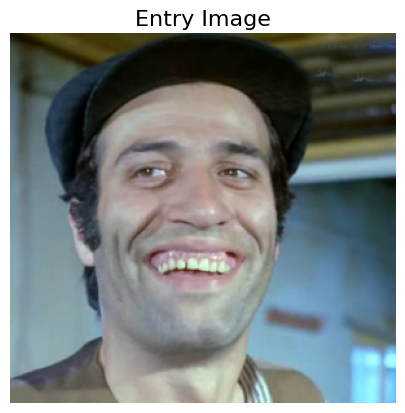

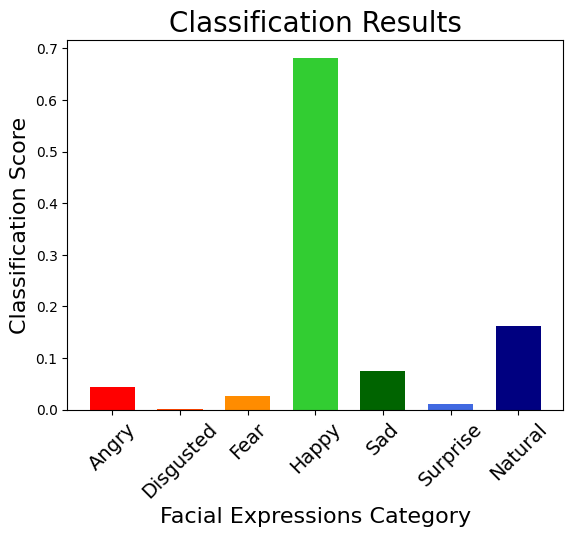

Classification result with the highest rate: Happy


In [27]:
# Classes 7 emotional states

class_names = ['Angry', 'Disgusted', 'Fear', 'Happy', 'Sad', 'Surprise', 'Natural']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# Draw our test image

plt.imshow(test_image_original)
plt.title('Entry Image', fontsize=16)
plt.axis('off')
plt.show()

# Let's color our results

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Classification Results", fontsize=20)
plt.xlabel("Facial Expressions Category",fontsize=16)
plt.ylabel("Classification Score",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Classification result with the highest rate:", class_names[np.argmax(results)])